### Student Information
Name: 王又賢

Student ID: 111080602

GitHub ID: beck-wang

Kaggle name: beck_wang

Kaggle private scoreboard snapshot:

[Snapshot](../pics/pic0.png)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the DM2023-Lab2-master. You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 27th 11:59 pm, Wednesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 31th 11:59 pm, Sunday)__. 

## First Part: take home exercises

In [94]:
# %reset -f
import os
import str
import json
import nltk
import keras
import gensim
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


In [95]:
### training data
anger_train = pd.read_csv("../DMLab2/DM2023-Lab2-Master/data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("../DMLab2/DM2023-Lab2-Master/data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("../DMLab2/DM2023-Lab2-Master/data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("../DMLab2/DM2023-Lab2-Master/data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
# combine & shuffle 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)
train_df = train_df.sample(frac=1,random_state=168)
train_df.head()

,id,text,emotion,intensity
597,10597,Trumpism likewise rests on a bed of racial res...,anger,0.417
2660,30656,@hoemanda69 wtf is tenacious and jubilant,joy,0.312
3197,40370,@questlove when are people going to realize th...,sadness,0.500
2801,30797,half day tuhday but nah for glee 😭,joy,0.125
818,10818,@WWE is the live event Brock vs Orton 2 this S...,anger,0.208


In [96]:
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))

count_vect = CountVectorizer()
# Learn the vocabulary and return document-term matrix
train_df_counts = count_vect.fit_transform(train_df.text) 
print(f"shape: {train_df_counts.shape}")

# Create a DataFrame with word and counts
train_freq_df = pd.DataFrame({'word': count_vect.get_feature_names_out(), 
                             'count': train_df_counts.sum(axis=0).A1})

print("\n=== word frequency for Top 30 words in train dataset ===")
train_freq_df_sorted = train_freq_df.sort_values(by='count', ascending=False)
train_freq_df_sorted.head(30)

shape: (3613, 10115)

=== word frequency for Top 30 words in train dataset ===


,word,count
8930,the,1736
9119,to,1289
537,and,955
10051,you,796
6371,of,793
4546,is,787
4571,it,717
4383,in,626
8924,that,537
5957,my,535


In [97]:
### testing data
anger_test = pd.read_csv("../DMLab2/DM2023-Lab2-Master/data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("../DMLab2/DM2023-Lab2-Master/data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("../DMLab2/DM2023-Lab2-Master/data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("../DMLab2/DM2023-Lab2-Master/data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine & shuffle 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
test_df = test_df.sample(frac=1,random_state=404)
test_df.head()

,id,text,emotion,intensity
300,40813,This shit hurting my heart 😪 that's how seriou...,sadness,0.875
195,30824,Nawaz Sharif is getting more funnier than @kap...,joy,0.700
283,40796,Public products: high downhearted price tag co...,sadness,0.354
299,40812,@StaceyDavidson_ You're a thief and a liberal ...,sadness,0.667
240,30869,Chris would take full responsibility and would...,joy,0.280


In [98]:
test_df['text_tokenized'] = test_df['text'].apply(lambda x: nltk.word_tokenize(x))

count_vect = CountVectorizer()
# Learn the vocabulary and return document-term matrix
test_df_counts = count_vect.fit_transform(test_df.text) 
print(f"shape: {test_df_counts.shape}")

# Create a DataFrame with word and counts
test_freq_df = pd.DataFrame({'word': count_vect.get_feature_names_out(), 
                             'count': test_df_counts.sum(axis=0).A1})

print("\n=== word frequency for Top 30 words in test dataset ===")
test_freq_df_sorted = test_freq_df.sort_values(by='count', ascending=False)
test_freq_df_sorted.head(30)

shape: (347, 1949)

=== word frequency for Top 30 words in test dataset ===


,word,count
1687,the,153
1739,to,138
99,and,92
1240,of,83
909,it,83
1938,you,82
903,is,77
867,in,69
655,for,57
1686,that,55


---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_1000 = TfidfVectorizer(max_features=1000, tokenizer=nltk.word_tokenize) # 1000 features
tfidf_1000.fit(train_df['text'])

train_tfidf_1000 = tfidf_1000.transform(train_df['text'])

feature_names = tfidf_1000.get_feature_names_out()
feature_names[100:110]

array(['awful', 'b', 'baby', 'back', 'bad', 'ball', 'balls', 'bb18', 'bc',
       'bday'], dtype=object)

---
### ** >>> Exercise 3 (Take home): **  


In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

              precision    recall  f1-score   support

       anger       0.66      0.68      0.67        84
        fear       0.66      0.69      0.67       110
         joy       0.72      0.71      0.71        79
     sadness       0.70      0.64      0.67        74

    accuracy                           0.68       347
   macro avg       0.68      0.68      0.68       347
weighted avg       0.68      0.68      0.68       347

=== Confusion matrix of DecisionTree model(with BOW_500) ===


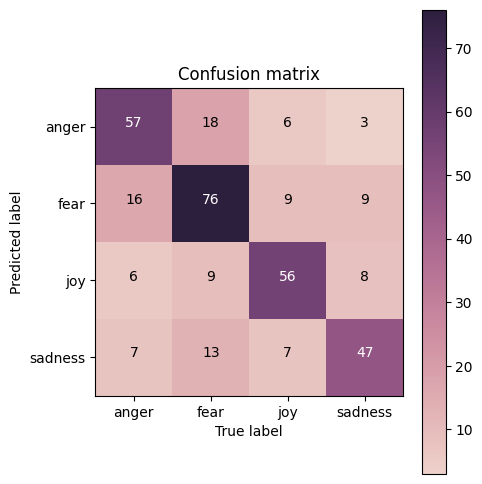

In [101]:
# DecisionTree model(with BOW_500) 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 
BOW_500.fit(train_df['text'])

X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

DT_model = DecisionTreeClassifier(random_state=1)
DT_model = DT_model.fit(X_train, y_train)

y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(classification_report(y_true=y_test, y_pred=y_test_pred))

print("=== Confusion matrix of DecisionTree model(with BOW_500) ===")
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

#### Can you interpret the results above? What do they mean?
- The blocks corresponding to the **"Pre_fear" to "True_anger"** & **"Pre_anger" to "True_fear"** both have high values, exceeding 10. This suggests that the model frequently misclassifies instances of sadness and anger, indicating confusion between these two emotions.
    
    &rArr; Here show a potential challenge in distinguishing between these two emotions, suggesting the need for cautious consideration when handling predictions related to them.

- Specifically, only the block of "Pre_sad" to "True_fear" has a notably higher value. This implies that the model is relatively more successful in correctly identifying instances of sadness within the context of fear, demonstrating a comparatively better ability to discern sadness from fear.

---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

              precision    recall  f1-score   support

       anger       0.63      0.65      0.64        84
        fear       0.73      0.77      0.75       110
         joy       0.78      0.71      0.74        79
     sadness       0.64      0.62      0.63        74

    accuracy                           0.70       347
   macro avg       0.70      0.69      0.69       347
weighted avg       0.70      0.70      0.70       347

=== Confusion matrix of Naive Bayes model(with BOW_500) ===


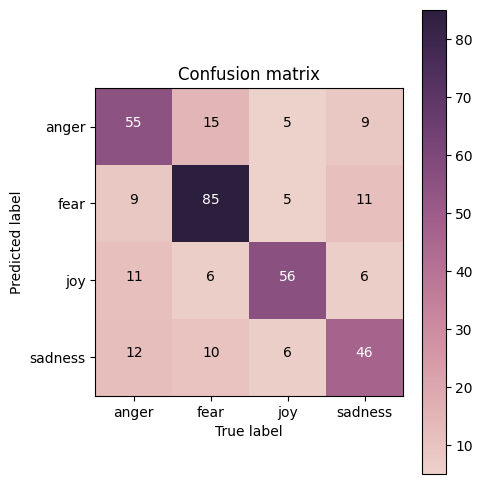

In [102]:
# Naive Bayes model(with BOW_500)
from sklearn.naive_bayes import MultinomialNB

X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']


NB_model = MultinomialNB(force_alpha=True)
NB_model = NB_model.fit(X_train, y_train)

y_train_pred = NB_model.predict(X_train)
y_test_pred = NB_model.predict(X_test)

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(classification_report(y_true=y_test, y_pred=y_test_pred))

print("=== Confusion matrix of Naive Bayes model(with BOW_500) ===")
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

              precision    recall  f1-score   support

       anger       0.74      0.76      0.75        84
        fear       0.78      0.79      0.78       110
         joy       0.85      0.78      0.82        79
     sadness       0.72      0.74      0.73        74

    accuracy                           0.77       347
   macro avg       0.77      0.77      0.77       347
weighted avg       0.77      0.77      0.77       347

=== Confusion matrix of Naive Bayes model(with BOW_1000) ===


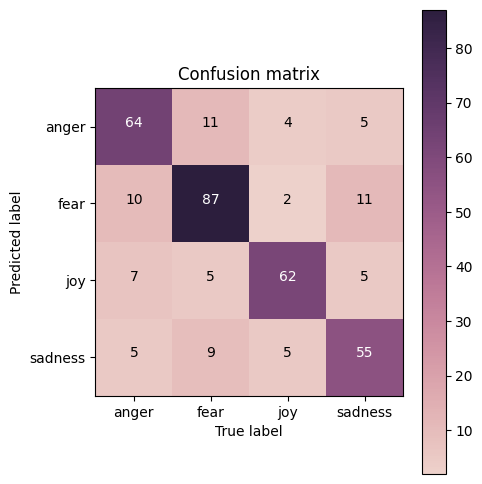

In [103]:
# Naive Bayes model(with BOW_1000)
from sklearn.naive_bayes import MultinomialNB

BOW_1000 = CountVectorizer(max_features=1000, tokenizer=nltk.word_tokenize) 
BOW_1000.fit(train_df['text'])

X_train = BOW_1000.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_1000.transform(test_df['text'])
y_test = test_df['emotion']

NB_model = MultinomialNB(force_alpha=True)
NB_model = NB_model.fit(X_train, y_train)

y_train_pred = NB_model.predict(X_train)
y_test_pred = NB_model.predict(X_test)

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(classification_report(y_true=y_test, y_pred=y_test_pred))

print("=== Confusion matrix of Naive Bayes model(with BOW_1000) ===")
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

              precision    recall  f1-score   support

       anger       0.85      0.71      0.77        84
        fear       0.66      0.92      0.77       110
         joy       0.86      0.75      0.80        79
     sadness       0.85      0.61      0.71        74

    accuracy                           0.76       347
   macro avg       0.80      0.75      0.76       347
weighted avg       0.79      0.76      0.76       347

=== Confusion matrix of Naive Bayes model(with tfidf_1000) ===


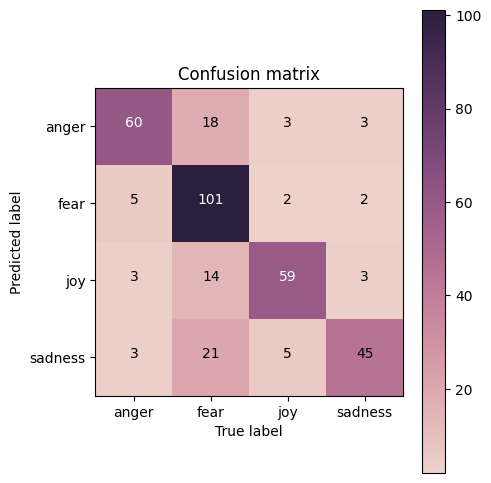

In [104]:
# Naive Bayes model(with tfidf_1000)
from sklearn.naive_bayes import MultinomialNB

X_train = tfidf_1000.transform(train_df['text'])
y_train = train_df['emotion']

X_test = tfidf_1000.transform(test_df['text'])
y_test = test_df['emotion']

NB_model = MultinomialNB(force_alpha=True)
NB_model = NB_model.fit(X_train, y_train)

y_train_pred = NB_model.predict(X_train)
y_test_pred = NB_model.predict(X_test)

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(classification_report(y_true=y_test, y_pred=y_test_pred))

print("=== Confusion matrix of Naive Bayes model(with tfidf_1000) ===")
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

### Score
| Model (Features) | Accuracy | Precision (anger, fear, joy, sadness) | Recall (anger, fear, joy, sadness) | F1-Score (anger, fear, joy, sadness) |
| --- | -------- | -------------------------------------- | ---------------------------------- | ------------------------------------ |
| Decision Tree (BOW_500)               | 68%      | 0.66, 0.66, 0.72, 0.70 | 0.68, 0.69, 0.71, 0.64 | 0.67, 0.67, 0.71, 0.67 |
| Naive Bayes (BOW_500)                 | 70%      | 0.63, 0.73, 0.78, 0.64 | 0.65, 0.77, 0.71, 0.62 | 0.64, 0.75, 0.74, 0.63 |
| Naive Bayes (BOW_1000)                | 77%      | 0.74, 0.78, 0.85, 0.72 | 0.76, 0.79, 0.78, 0.74 | 0.75, 0.78, 0.82, 0.73 |
| Naive Bayes (tfidf_1000)              | 76%      | 0.85, 0.66, 0.86, 0.85 | 0.71, 0.92, 0.75, 0.61 | 0.77, 0.77, 0.80, 0.71 |

### Summary

In a nutshell, the Naive Bayes model with BOW_1000 features stands out with approximately **77%** accuracy. The tfidf features don't improve the model's performace. _**The Decision Tree and Naive Bayes models**_ with BOW_500 are _**close in performance**_, with slight variations in different emotion categories.

### Interpretation of result
1. Model Complexity:
    - Decision Tree vs. Naive Bayes Models:
        - Decision Tree models are relatively simple and may struggle with complex relationships in the data, potentially leading to poorer performance.
        - Naive Bayes models, despite assuming independence between features (which may not hold true in reality), demonstrate slightly _**better**_ performance in this exercise.

2. Feature Representation:

    - BOW_500 vs. BOW_1000:
        - The number of features significantly influences model performance, with BOW_1000(77%) outperforming BOW_500(70%).
    - BOW_1000 vs. tfidf_1000:
        - This result actully shock me become bag-of-words(76%) perform better than TF-IDF(76%). This suggests that, in this case the choice of feature representation do not plays a crucial role in determining model performance.

---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots), just like the images below.(Note: the pictures below are an example from a different model). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?
<table><tr>
    <td><img src="pics/pic3.png" style="width: 300px;"/> </td>
    <td><img src="pics/pic4.png" style="width: 300px;"/> </td>
</tr></table>

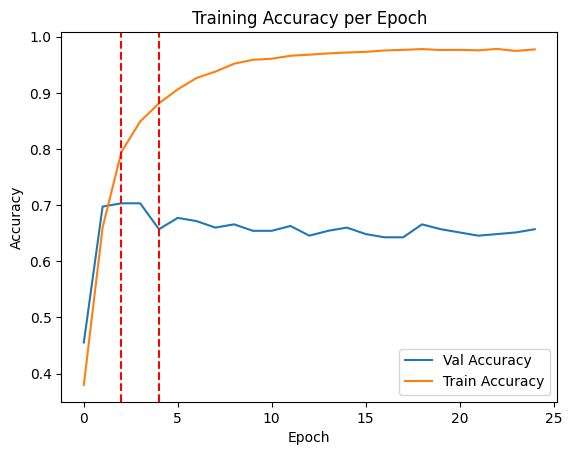

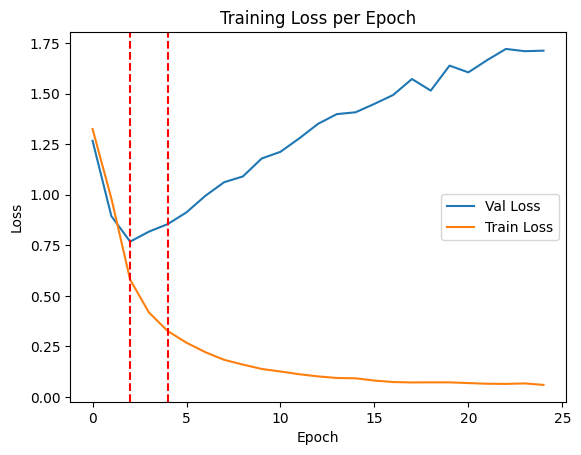

In [105]:
log_df = pd.read_csv("../DMLab2/DM2023-Lab2-Master/logs/training_log.csv")
acc_df = log_df.iloc[:,[0, 1, 3]]
loss_df = log_df.iloc[:,[0, 2, 4]]

sns.lineplot(data=acc_df, x="epoch", y="val_accuracy", label="Val Accuracy")
sns.lineplot(data=acc_df, x="epoch", y="accuracy", label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.axvline(x=2, color='red', linestyle='--')
plt.axvline(x=4, color='red', linestyle='--')
plt.legend()
plt.show()


sns.lineplot(data=loss_df, x="epoch", y="val_loss", label="Val Loss")
sns.lineplot(data=loss_df, x="epoch", y="loss", label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.axvline(x=2, color='red', linestyle='--')
plt.axvline(x=4, color='red', linestyle='--')
plt.legend()
plt.show()

- **Accuracy**: We can see the training accuracy is **consistently improving** and getting high value while the validation accuracy plateaus or decreases, it might be a sign of overfitting.

- **Loss**: Similar to accuracy, the training loss is **consistently decreasing** while the validation loss plateaus or increases, it may also suggest overfitting.

- **Summary**: It will be good that we choise **2** to **4** epochs as our model training. Before 2 epochs indicate the underfitting, while after the 4 epochs represent the overfitting.

---
### ** >>> Exercise 7 (Take home): **  

Now, we have the word vectors, but our input data is a sequence of words (or say sentence). 
How can we utilize these "word" vectors to represent the sentence data and train our model?


Here are two elemental way to do this: 
1. Average of Word Embeddings:
    Initially, we use a tokenizer to separate each word, transforming all words into vectors to build a tensor. After that, we employ np.mean() to obtain the average vector from the tensor.

2. Weighted Average of Word Embeddings:
    Similar to the Average of Word Embeddings, but we incorporate weighted values provided by other methods such as tf-idf.Then utilize np.average() to compute the result.

These approaches transform seq2vec by utilizing word vectors, enabling us to capture semantic information for the entire sentence. Moreover, we can use these vectors as input for model training.

The code in the cell below is the easy method for Average of Word Embeddings(sourse: https://datascience.stackexchange.com/questions/107012/how-to-calculate-the-mean-average-of-word-embedding-and-then-compare-strings-usi).

In [106]:
import gensim
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

# load word2vec
model_path = "../master/GoogleNews/GoogleNews-vectors-negative300.bin"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok') # check model loading

# inputs
first_sentence_list = ['driver', 'backs', 'into', 'stroller', 'with', 'child', ',', 'drives', 'off']
second_sentence_list = ['driver', 'backs', 'into', 'mom', ',', 'stroller', 'with', 'child', 'then', 'drives', 'off']

# remove OOV(Out-of-vocabulary)
first = [word for word in first_sentence_list if word in w2v_google_model.key_to_index]
second = [word for word in second_sentence_list if word in w2v_google_model.key_to_index]

# average word embeddings to get sentence embeddings
first_sent_embedding = np.mean(w2v_google_model[first], axis=0)
second_sent_embedding = np.mean(w2v_google_model[second], axis=0)

# calculate similarities
result = cosine_similarity(first_sent_embedding.reshape(1,-1),second_sent_embedding.reshape(1,-1))

print(result)

load ok
[[0.9709225]]


In [109]:
# different inputs
first_sentence_list = train_df["text_tokenized"][0]
second_sentence_list = train_df["text_tokenized"][1]

# remove OOV(Out-of-vocabulary)
first = [word for word in first_sentence_list if word in w2v_google_model.key_to_index]
second = [word for word in second_sentence_list if word in w2v_google_model.key_to_index]

# average word embeddings to get sentence embeddings
first_sent_embedding = np.mean(w2v_google_model[first], axis=0)
second_sent_embedding = np.mean(w2v_google_model[second], axis=0)

# calculate similarities
result = cosine_similarity(first_sent_embedding.reshape(1,-1),second_sent_embedding.reshape(1,-1))

print(result)

[[0.755183]]


---
### ** >>> Exercise 8 (Take home): **  

Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

In [107]:
model_path = "../master/GoogleNews/GoogleNews-vectors-negative300.bin"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok') # check model loading

word_list = ["angry", "happy", "sad", "fear" ]

topn = 15 # to show the 15 words most related
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
sad_words = ['sad'] + [word_ for word_, sim_ in w2v_google_model.most_similar('sad', topn=topn)]        
fear_words = ['fear'] + [word_ for word_, sim_ in w2v_google_model.most_similar('fear', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('sad_words: ', sad_words)
print('fear_words: ', fear_words)

target_words = happy_words + angry_words + sad_words + fear_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['g'] * cn + ['r'] * cn + ['b'] * cn + ['y'] * cn # change color 
print(color)

load ok
happy_words:  ['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Said_Hirschbeck', 'elated', 'thankful', 'unhappy']
angry_words:  ['angry', 'irate', 'enraged', 'indignant', 'incensed', 'annoyed', 'agitated', 'frustrated', 'furious', 'unhappy', 'outraged', 'livid', 'irritated', 'exasperated', 'angrier', 'Angry']
sad_words:  ['sad', 'saddening', 'Sad', 'saddened', 'heartbreaking', 'disheartening', 'Meny_Friedman', 'parishioner_Pat_Patello', 'saddens_me', 'distressing', 'reminders_bobbing', 'Turkoman_Shiites', 'saddest', 'unfortunate', 'sorry', 'bittersweet']
fear_words:  ['fear', 'fearful', 'fears', 'Fear', 'fearing', 'worry', 'dread', 'feared', 'anxiety', 'apprehension', 'afraid', 'worries', 'concern', 'distrust', 'worried', 'Fearful']

target words: 
['happy', 'glad', 'pleased', 'ecstatic', 'overjoyed', 'thrilled', 'satisfied', 'proud', 'delighted', 'disappointed', 'excited', 'happier', 'Sa

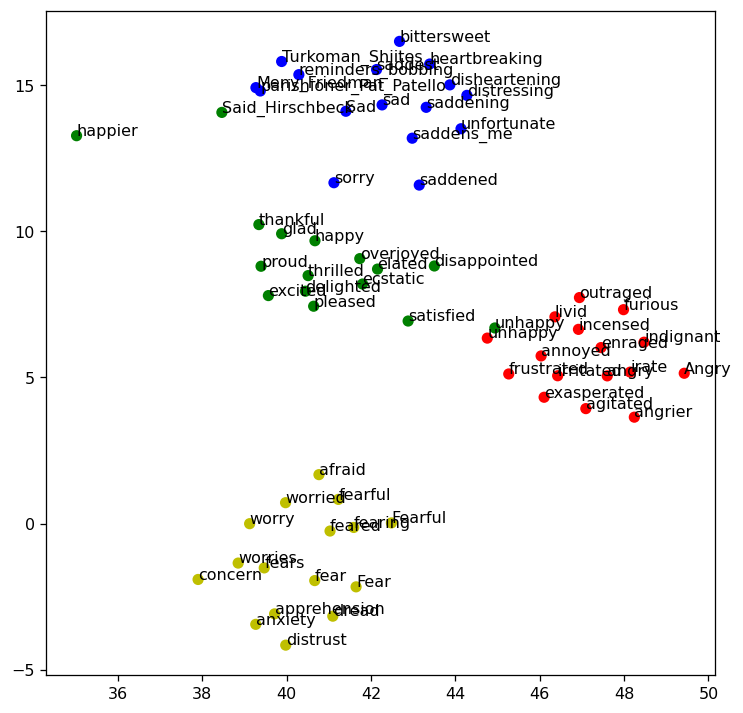

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 1000 # change size from 200 to 1000
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

## Second Part: Report of Kaggle Competition

---

In [64]:
# %reset -f
import os
import str
import json
import nltk
import keras
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from keras.callbacks import CSVLogger

### Data Pre_processing
Initially, I converted the data from .json format to .pkl for easier IO operations. Upon observation, I noted that all data sources and types were consistent, so I did not include them in the dataset.

In [13]:
tweet_df = pd.DataFrame(columns=["tweet_id","score","index","hashtag","text","crawldate"])
data_list = []

with open("tweets_DM.json", "r") as json_file:
    for line in json_file:
        json_dict = json.loads(line)
        data_list.append({
        "tweet_id":json_dict["_source"]["tweet"]["tweet_id"],
        "score":json_dict["_score"],
        "index":json_dict["_index"],
        "hashtag":json_dict["_source"]["tweet"]["hashtags"],
        "text":json_dict["_source"]["tweet"]["text"],
        "crawldate":json_dict["_crawldate"]
        })

tweet_df = pd.DataFrame(data_list)
tweet_df.to_pickle("tweets_dataframe.pkl")

In [65]:
df = pd.read_pickle("tweets_dataframe.pkl")
print(f"dataframe legnth before clearing: {len(df)}")
df # check data loading and dataframe shape(1867535 rows × 6 columns)

dataframe legnth before clearing: 1867535


,tweet_id,score,index,hashtag,text,crawldate
0,0x376b20,391,hashtag_tweets,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",2015-05-23 11:42:47
1,0x2d5350,433,hashtag_tweets,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",2016-01-28 04:52:09
2,0x28b412,232,hashtag_tweets,[bibleverse],"Confident of your obedience, I write to you, k...",2017-12-25 04:39:20
3,0x1cd5b0,376,hashtag_tweets,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,2016-01-24 23:53:05
4,0x2de201,989,hashtag_tweets,[],"""Trust is not the same as faith. A friend is s...",2016-01-08 17:18:59
...,...,...,...,...,...,...
1867530,0x316b80,827,hashtag_tweets,"[mixedfeeling, butimTHATperson]",When you buy the last 2 tickets remaining for ...,2015-05-12 12:51:52
1867531,0x29d0cb,368,hashtag_tweets,[],I swear all this hard work gone pay off one da...,2017-10-02 17:54:04
1867532,0x2a6a4f,498,hashtag_tweets,[],@Parcel2Go no card left when I wasn't in so I ...,2016-10-10 11:04:32
1867533,0x24faed,840,hashtag_tweets,[],"Ah, corporate life, where you can date <LH> us...",2016-09-02 14:25:06


#### Data Cleaning & Preprocessing
I discovered that the text contains some notes resembling HTML code (e.g., <LH>), which could be noise in the dataset. Consequently, I removed the code from the text. Additionally, I determined that user IDs may not be crucial for emotion detection, so I opted to remove them as well.

In [66]:
df_pre = df.replace({"text":"<LH>"},{"text":""},regex=True)
df_pre = df_pre.replace({"text":r"@[^ ]+"},{"text":""},regex=True)
print(f"dataframe legnth after clearing: {len(df_pre)}")
df_pre # check dataframe shape is same after data cleaning(1867535 rows × 6 columns)

dataframe legnth after clearing: 1867535


,tweet_id,score,index,hashtag,text,crawldate
0,0x376b20,391,hashtag_tweets,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",2015-05-23 11:42:47
1,0x2d5350,433,hashtag_tweets,"[freepress, TrumpLegacy, CNN]","As we see, Trump is dangerous to #freepress a...",2016-01-28 04:52:09
2,0x28b412,232,hashtag_tweets,[bibleverse],"Confident of your obedience, I write to you, k...",2017-12-25 04:39:20
3,0x1cd5b0,376,hashtag_tweets,[],Now ISSA is stalking Tasha 😂😂😂,2016-01-24 23:53:05
4,0x2de201,989,hashtag_tweets,[],"""Trust is not the same as faith. A friend is s...",2016-01-08 17:18:59
...,...,...,...,...,...,...
1867530,0x316b80,827,hashtag_tweets,"[mixedfeeling, butimTHATperson]",When you buy the last 2 tickets remaining for ...,2015-05-12 12:51:52
1867531,0x29d0cb,368,hashtag_tweets,[],I swear all this hard work gone pay off one da...,2017-10-02 17:54:04
1867532,0x2a6a4f,498,hashtag_tweets,[],no card left when I wasn't in so I have no id...,2016-10-10 11:04:32
1867533,0x24faed,840,hashtag_tweets,[],"Ah, corporate life, where you can date using ...",2016-09-02 14:25:06


In [69]:
# Add identification tag with data after clearing 
iden_df = pd.read_csv("data_identification.csv")
merged_df = pd.merge(df_pre, iden_df, on="tweet_id")
tweet_max_length = merged_df['text'].apply(len).max()
print(f"maximum of tweet's text length: {tweet_max_length}") # check text maximum to prevent overflow

# Seperate training set and test set
train_df = merged_df[merged_df["identification"]=="train"]
test_df = merged_df[merged_df["identification"]=="test"]

# Add answer tag with training set
answer_df = pd.read_csv("emotion.csv")
train_df = pd.merge(train_df, answer_df, on="tweet_id")
train_df

maximum of tweet's text length: 248


,tweet_id,score,index,hashtag,text,crawldate,identification,emotion
0,0x376b20,391,hashtag_tweets,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",2015-05-23 11:42:47,train,anticipation
1,0x2d5350,433,hashtag_tweets,"[freepress, TrumpLegacy, CNN]","As we see, Trump is dangerous to #freepress a...",2016-01-28 04:52:09,train,sadness
2,0x1cd5b0,376,hashtag_tweets,[],Now ISSA is stalking Tasha 😂😂😂,2016-01-24 23:53:05,train,fear
3,0x1d755c,120,hashtag_tweets,"[authentic, LaughOutLoud]",Thx for the BEST TIME tonight. What stories!...,2015-06-11 04:44:05,train,joy
4,0x2c91a8,1021,hashtag_tweets,[],Still waiting on those supplies Liscus.,2015-08-18 02:30:07,train,anticipation
...,...,...,...,...,...,...,...,...
1455558,0x321566,94,hashtag_tweets,"[NoWonder, Happy]",I'm SO HAPPY!!! #NoWonder the name of this sho...,2016-12-26 02:44:07,train,joy
1455559,0x38959e,627,hashtag_tweets,[],In every circumtance I'd like to be thankful t...,2015-04-01 08:14:56,train,joy
1455560,0x2cbca6,274,hashtag_tweets,[blessyou],there's currently two girls walking around the...,2016-11-17 23:46:22,train,joy
1455561,0x24faed,840,hashtag_tweets,[],"Ah, corporate life, where you can date using ...",2016-09-02 14:25:06,train,joy


#### Generate Validation Data by Sampling
Select 10% of train set as validation set.

In [71]:
np.random.seed(50)
valid_df = train_df.sample(frac=0.1)
sampled_train_df = train_df.drop(valid_df.index)
print(f"validation dataframe's legnth: {len(sampled_train_df)}")
sampled_train_df

validation dataframe's legnth: 1310007


,tweet_id,score,index,hashtag,text,crawldate,identification,emotion
0,0x376b20,391,hashtag_tweets,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",2015-05-23 11:42:47,train,anticipation
1,0x2d5350,433,hashtag_tweets,"[freepress, TrumpLegacy, CNN]","As we see, Trump is dangerous to #freepress a...",2016-01-28 04:52:09,train,sadness
2,0x1cd5b0,376,hashtag_tweets,[],Now ISSA is stalking Tasha 😂😂😂,2016-01-24 23:53:05,train,fear
3,0x1d755c,120,hashtag_tweets,"[authentic, LaughOutLoud]",Thx for the BEST TIME tonight. What stories!...,2015-06-11 04:44:05,train,joy
6,0x249c0c,827,hashtag_tweets,[LeagueCup],More highlights are being shown than actual ...,2016-04-18 13:01:02,train,sadness
...,...,...,...,...,...,...,...,...
1455558,0x321566,94,hashtag_tweets,"[NoWonder, Happy]",I'm SO HAPPY!!! #NoWonder the name of this sho...,2016-12-26 02:44:07,train,joy
1455559,0x38959e,627,hashtag_tweets,[],In every circumtance I'd like to be thankful t...,2015-04-01 08:14:56,train,joy
1455560,0x2cbca6,274,hashtag_tweets,[blessyou],there's currently two girls walking around the...,2016-11-17 23:46:22,train,joy
1455561,0x24faed,840,hashtag_tweets,[],"Ah, corporate life, where you can date using ...",2016-09-02 14:25:06,train,joy


#### Tokenization & Data Transformation
Employ the NLTK tokenizer and set the maximum features to 700 for data transformation.

In [72]:
# build analyzers (bag-of-words)
BOW_700 = CountVectorizer(max_features=700, tokenizer=nltk.word_tokenize) 
BOW_700.fit(train_df['text'])

# standardize name (X, y)
X_train = BOW_700.transform(sampled_train_df['text'])
y_train = sampled_train_df['emotion']

X_valid = BOW_700.transform(valid_df['text'])
y_valid = valid_df['emotion']

In [73]:
# check X & y dimension
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_valid.shape: ', X_valid.shape)
print('y_valid.shape: ', y_valid.shape)

X_train.shape:  (1310007, 700)
y_train.shape:  (1310007,)
X_valid.shape:  (145556, 700)
y_valid.shape:  (145556,)


In [74]:
# deal with label (string -> one-hot)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:8]:\n', y_train[0:8])
print('\ny_train.shape: ', y_train.shape)
print('y_valid.shape: ', y_valid.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_valid = label_encode(label_encoder, y_valid)

print('\n\n## After convert')
print('y_train[0:8]:\n', y_train[0:8])
print('\ny_train.shape: ', y_train.shape)
print('y_valid.shape: ', y_valid.shape)


check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:8]:
 0     anticipation
1          sadness
2             fear
3              joy
6          sadness
7     anticipation
9            anger
10             joy
Name: emotion, dtype: object

y_train.shape:  (1310007,)
y_valid.shape:  (145556,)


## After convert
y_train[0:8]:
 [[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]

y_train.shape:  (1310007, 8)
y_valid.shape:  (145556, 8)


#### Modeling (3 layer MLP)
It use the classic ReLU function as activation function and the softmax function to normalizing output.

In [75]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

# input layer
model_input = Input(shape=(input_shape, )) # 700 
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

input_shape:  700
output_shape:  8
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 700)]             0         
                                                                 
 dense (Dense)               (None, 64)                44864     
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 softmax (Softmax)        

In [ ]:
csv_logger = CSVLogger('training_log_2.csv')

# training setting
epochs = 5
batch_size = 16

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_valid, y_valid))
print('training finish')

Epoch 1/5


c:\Users\Wang\.conda\envs\datamining\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


81876/81876 [==============================] - 120s 1ms/step - loss: 1.4300 - accuracy: 0.4784 - val_loss: 1.4029 - val_accuracy: 0.4888
Epoch 2/5
81876/81876 [==============================] - 124s 1ms/step - loss: 1.3929 - accuracy: 0.4922 - val_loss: 1.3937 - val_accuracy: 0.4924
Epoch 3/5
81876/81876 [==============================] - 129s 2ms/step - loss: 1.3831 - accuracy: 0.4966 - val_loss: 1.3912 - val_accuracy: 0.4937
Epoch 4/5
81876/81876 [==============================] - 141s 2ms/step - loss: 1.3784 - accuracy: 0.4988 - val_loss: 1.3917 - val_accuracy: 0.4940
Epoch 5/5
81876/81876 [==============================] - 144s 2ms/step - loss: 1.3746 - accuracy: 0.5004 - val_loss: 1.3917 - val_accuracy: 0.4942
training finish


### Prediction and Evaluation

In [ ]:
# predict
X_test = BOW_500.transform(test_df["text"])
print(X_test.shape)
pred_result = model.predict(X_test)
pred_result[:5]

(411972, 700)
12875/12875 [==============================] - 13s 967us/step


array([[8.1461491e-03, 5.4569894e-01, 1.5552659e-02, 1.6919989e-02,
        2.4562092e-01, 3.1941745e-02, 4.9254438e-03, 1.3119410e-01],
       [1.8327028e-04, 8.1093049e-01, 9.6676726e-05, 5.0406228e-03,
        1.6501091e-02, 6.4302149e-04, 2.1952399e-05, 1.6658282e-01],
       [2.9279251e-02, 1.2067912e-01, 2.2795878e-01, 8.3569437e-03,
        8.7186113e-02, 4.5178416e-01, 3.0165562e-02, 4.4590037e-02],
       [7.7256473e-04, 1.2697464e-01, 4.4829454e-03, 1.1708947e-03,
        6.7898387e-01, 1.2356414e-02, 2.2760252e-03, 1.7298265e-01],
       [1.2284810e-02, 5.8074969e-01, 4.1913539e-02, 2.1313954e-02,
        1.1113514e-01, 5.0625864e-02, 4.5363302e-03, 1.7744054e-01]],
      dtype=float32)

In [ ]:
pred_emo = label_decode(label_encoder, pred_result)
print(len(pred_emo))
pred_emo[:5]

411972


array(['anticipation', 'anticipation', 'sadness', 'joy', 'anticipation'],
      dtype=object)

#### Result Output

In [24]:
test_df_id = pd.DataFrame(test_df["tweet_id"].copy().reset_index())
test_df_id = test_df_id.drop("index",axis=1)
test_df_id.columns = ["id"]
emo_df = pd.DataFrame(pred_emo, columns=["emotion"])

merged_output_df = pd.concat([test_df_id, emo_df], axis=1)
merged_output_df.to_csv("prediction_test.csv", index=False)
merged_output_df


,id,emotion
0,0x28b412,anticipation
1,0x2de201,anticipation
2,0x218443,sadness
3,0x2939d5,joy
4,0x26289a,anticipation
...,...,...
411967,0x2913b4,anticipation
411968,0x2a980e,anticipation
411969,0x316b80,sadness
411970,0x29d0cb,joy


#### Evaluation
Because in the previous tests, the loss started to increase after exceeding 4 epochs. Therefore, in subsequent tests, I experimented with using only 5 epochs. Surprisingly, there wasn't significant overfitting even with 5 epochs, so I decided to adopt this version.

15 epoch test

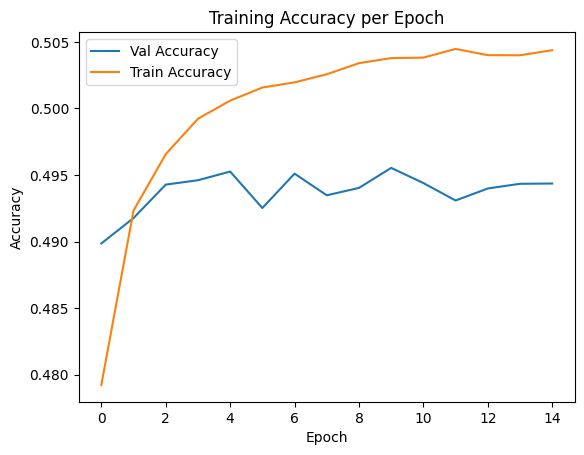

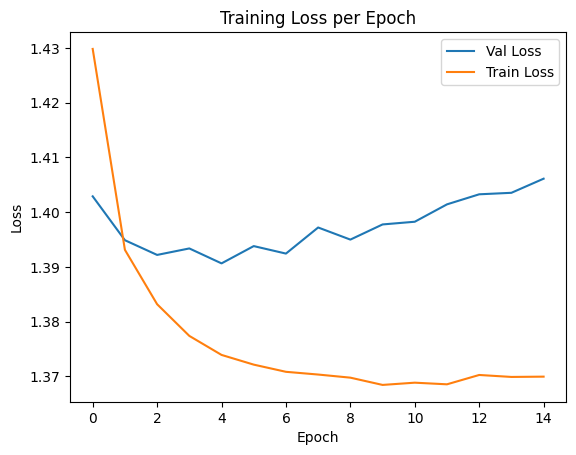

In [92]:
log_df = pd.DataFrame()
log_df = pd.read_csv("training_log_3.csv")

acc_df = log_df.iloc[:,[0, 1, 3]]
loss_df = log_df.iloc[:,[0, 2, 4]]

sns.lineplot(data=acc_df, x="epoch", y="val_accuracy", label="Val Accuracy")
sns.lineplot(data=acc_df, x="epoch", y="accuracy", label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()
plt.show()


sns.lineplot(data=loss_df, x="epoch", y="val_loss", label="Val Loss")
sns.lineplot(data=loss_df, x="epoch", y="loss", label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

5 epoch test

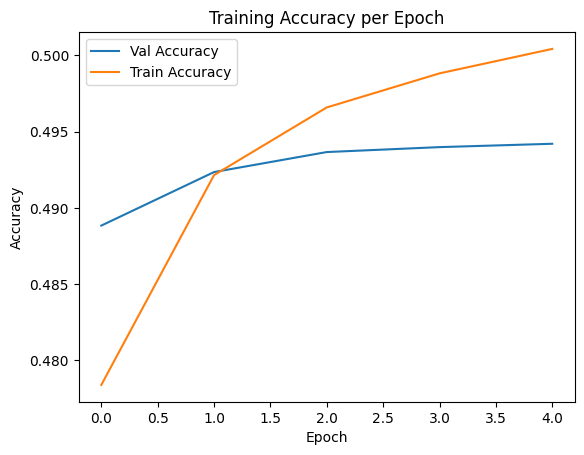

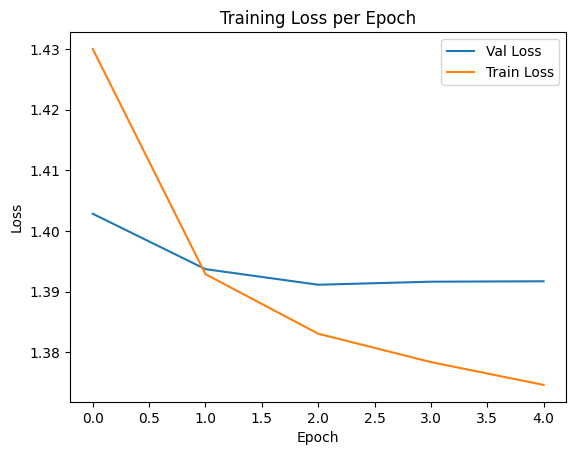

In [93]:
log_df = pd.DataFrame()
log_df = pd.read_csv("training_log_2.csv") 

acc_df = log_df.iloc[:,[0, 1, 3]]
loss_df = log_df.iloc[:,[0, 2, 4]]

sns.lineplot(data=acc_df, x="epoch", y="val_accuracy", label="Val Accuracy")
sns.lineplot(data=acc_df, x="epoch", y="accuracy", label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy per Epoch")
plt.legend()
plt.show()


sns.lineplot(data=loss_df, x="epoch", y="val_loss", label="Val Loss")
sns.lineplot(data=loss_df, x="epoch", y="loss", label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()